In [1]:
from xyz2graph import MolGraph, to_plotly_figure
import os
import pandas as pd
import re
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn import (linear_model, model_selection, preprocessing, pipeline)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/home/mickael/anaconda3/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/mickael/anaconda3/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/home/mickael/venv/lib/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/mickael/venv/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/home/micka

In [2]:
from scipy.spatial.distance import pdist
from kymatio.torch import HarmonicScattering3D
from kymatio.scattering3d.backend.torch_backend import TorchBackend3D
from kymatio.scattering3d.utils import generate_weighted_sum_of_gaussians
import time

#### Chemin pour les datasets

In [3]:
train_path = "./data/atoms/train/"
train_energy_path = "./data/energies/train.csv"
energies = pd.read_csv(train_energy_path)
test_path = "./data/atoms/test/"


#### Tableau périodique des élements

In [4]:
periodic_table = { '': 0,
    'H': 1, 'He': 2, 'Li': 3, 'Be': 4, 'B': 5, 'C': 6, 'N': 7, 'O': 8, 'F': 9, 'Ne': 10,
    'Na': 11, 'Mg': 12, 'Al': 13, 'Si': 14, 'P': 15, 'S': 16, 'Cl': 17, 'Ar': 18, 'K': 19, 'Ca': 20,
    'Sc': 21, 'Ti': 22, 'V': 23, 'Cr': 24, 'Mn': 25, 'Fe': 26, 'Co': 27, 'Ni': 28, 'Cu': 29, 'Zn': 30,
    'Ga': 31, 'Ge': 32, 'As': 33, 'Se': 34, 'Br': 35, 'Kr': 36, 'Rb': 37, 'Sr': 38, 'Y': 39, 'Zr': 40,
    'Nb': 41, 'Mo': 42, 'Tc': 43, 'Ru': 44, 'Rh': 45, 'Pd': 46, 'Ag': 47, 'Cd': 48, 'In': 49, 'Sn': 50,
    'Sb': 51, 'Te': 52, 'I': 53, 'Xe': 54, 'Cs': 55, 'Ba': 56, 'La': 57, 'Ce': 58, 'Pr': 59, 'Nd': 60,
    'Pm': 61, 'Sm': 62, 'Eu': 63, 'Gd': 64, 'Tb': 65, 'Dy': 66, 'Ho': 67, 'Er': 68, 'Tm': 69, 'Yb': 70,
    'Lu': 71, 'Hf': 72, 'Ta': 73, 'W': 74, 'Re': 75, 'Os': 76, 'Ir': 77, 'Pt': 78, 'Au': 79, 'Hg': 80,
    'Tl': 81, 'Pb': 82, 'Bi': 83, 'Po': 84, 'At': 85, 'Rn': 86, 'Fr': 87, 'Ra': 88, 'Ac': 89, 'Th': 90,
    'Pa': 91, 'U': 92, 'Np': 93, 'Pu': 94, 'Am': 95, 'Cm': 96, 'Bk': 97, 'Cf': 98, 'Es': 99, 'Fm': 100,
    'Md': 101, 'No': 102, 'Lr': 103, 'Rf': 104, 'Db': 105, 'Sg': 106, 'Bh': 107, 'Hs': 108, 'Mt': 109,
    'Ds': 110, 'Rg': 111, 'Cn': 112, 'Nh': 113, 'Fl': 114, 'Mc': 115, 'Lv': 116, 'Ts': 117, 'Og': 118
}

#### Visualisation d'une molecule du dataset d'entraînement

In [5]:
mg = MolGraph()
mg.read_xyz(train_path + "id_1.xyz")
fig = to_plotly_figure(mg)

In [6]:
fig.show()

#### Visualisation du dataset

In [7]:
metadata = []
for filename in tqdm(os.listdir(train_path)):
    mg = MolGraph()
    metadata_dict = dict()
    mg.read_xyz(train_path + filename)
    metadata_dict["id"] = int(re.findall(r"\d+", filename)[0])
    metadata_dict["nb_C"] = len(list(filter(lambda x: x == "C", mg.elements)))
    metadata_dict["nb_H"] = len(list(filter(lambda x: x == "H", mg.elements)))
    metadata_dict["nb_Atoms"] = len(mg.elements)
    metadata_dict["mean_dist"] = (
        sum(mg.bond_lengths.values()) / metadata_dict["nb_Atoms"]
    )
    metadata_dict["max_dist"] = max(mg.bond_lengths.values())
    metadata_dict["mean_radii"] = (
        sum(mg.atomic_radii) / metadata_dict["nb_Atoms"]
    )
    metadata_dict["max_radii"] = max(mg.atomic_radii)
    metadata.append(metadata_dict)
data = pd.DataFrame(metadata)
merged = pd.merge(data, energies, how="left", on="id")

100%|██████████| 4628/4628 [00:01<00:00, 2827.79it/s]


In [8]:
merged

,id,nb_C,nb_H,nb_Atoms,mean_dist,max_dist,mean_radii,max_radii,energy
0,1378,7,12,19,1.305474,1.768,0.395789,0.68,-90.382908
1,4261,7,14,21,1.378000,1.768,0.380000,0.68,-97.088127
2,2683,4,9,15,1.417000,1.768,0.410000,0.68,-67.964455
3,3231,7,12,19,1.305474,1.768,0.395789,0.68,-90.968990
4,3753,5,8,14,1.307429,1.768,0.422857,0.68,-68.327363
...,...,...,...,...,...,...,...,...,...
4623,2528,4,11,17,1.285471,1.768,0.388824,0.68,-74.593184
4624,3879,7,12,19,1.305474,1.768,0.395789,0.68,-90.850472
4625,3291,5,11,17,1.389471,1.768,0.388824,0.68,-76.261498
4626,4410,7,12,19,1.305474,1.768,0.395789,0.68,-91.235288


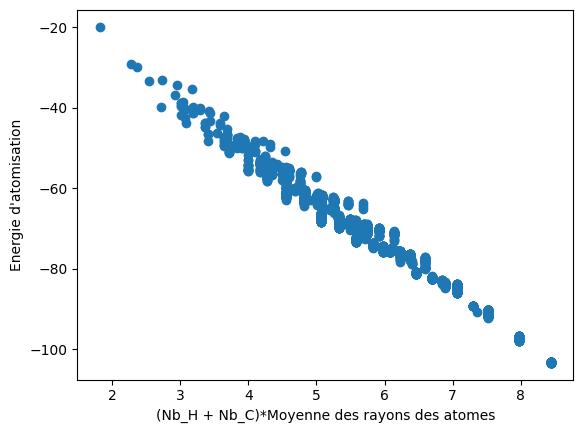

In [9]:
plt.scatter((merged["nb_H"] + merged["nb_C"]) * merged["mean_radii"], merged["energy"])
plt.xlabel("(Nb_H + Nb_C)*Moyenne des rayons des atomes")
plt.ylabel("Energie d'atomisation")
plt.title("")
plt.show()

## Prétraitemen des données

#### Sur les données d'entraînement

In [10]:
molecule_data = []
ids = []
num_atoms = []
MAX_ELEMENTS = 23
for filename in tqdm(os.listdir(train_path)):
    mg = MolGraph()
    molecule_dict = dict()
    mg.read_xyz(train_path + filename)
    molecule_dict["id"] = int(re.findall(r"\d+", filename)[0])
    molecule_dict["num_atoms"] = len(mg.elements)
    indices = range(molecule_dict["num_atoms"])
    
    molecule_dict["atoms"] = np.zeros(MAX_ELEMENTS, dtype=str)
    np.put(molecule_dict["atoms"], indices, mg.elements)
    molecule_dict["x"] = np.zeros(MAX_ELEMENTS)
    np.put(molecule_dict["x"], indices, mg.x)
    molecule_dict["y"] = np.zeros(MAX_ELEMENTS)
    np.put(molecule_dict["y"], indices, mg.y)
    molecule_dict["z"] = np.zeros(MAX_ELEMENTS)
    np.put(molecule_dict["z"], indices, mg.z)
    molecule_dict["atomic_numbers"] = np.array(list(map(lambda x: periodic_table[x], molecule_dict["atoms"])))
    molecule_data.append(molecule_dict)

data_mol = pd.DataFrame(molecule_data)

100%|██████████| 4628/4628 [00:01<00:00, 2627.14it/s]


In [11]:
data_mol

,id,num_atoms,atoms,x,y,z,atomic_numbers
0,1378,19,"[C, C, C, C, C, C, C, H, H, H, H, H, H, H, H, ...","[-3.422678, -2.214776, -0.7515, -0.173601, 1.3...","[0.272019, 0.252711, 0.232221, 0.087406, 0.152...","[1.027664, 1.013301, 1.003735, -0.412957, -0.4...","[6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,4261,21,"[C, C, C, C, C, C, C, H, H, H, H, H, H, H, H, ...","[-0.762414, -0.857188, 0.165888, -0.061294, 1....","[-1.564976, -0.075698, 0.778435, 0.799366, 1.3...","[1.689475, 1.9964, 1.232484, -0.274357, -1.183...","[6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,2683,15,"[O, C, C, C, C, N, H, H, H, H, H, H, H, H, H, ...","[0.831782, 1.093163, -0.22282, -1.134508, -0.8...","[-2.146051, -0.822155, -0.136907, 0.279113, 1....","[0.310662, -0.119359, -0.490743, 0.682003, 0.3...","[8, 6, 6, 6, 6, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,3231,19,"[C, C, C, C, C, C, C, H, H, H, H, H, H, H, H, ...","[-2.102219, -1.552018, -0.939505, 0.520376, 1....","[1.465102, 0.331327, 0.149637, -0.344522, -0.5...","[2.090851, 1.65539, 0.294256, 0.374877, -0.986...","[6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,3753,14,"[C, C, C, O, C, C, H, H, H, H, H, H, H, H, , ,...","[-2.378177, -1.17025, 0.3244, 0.773171, 0.8502...","[0.006156, 0.014099, 0.022966, 1.145889, -1.28...","[0.01694, -0.011043, -0.008448, 0.767368, 0.63...","[6, 6, 6, 8, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 0, ..."
...,...,...,...,...,...,...,...
4623,2528,17,"[C, C, C, C, N, O, H, H, H, H, H, H, H, H, H, ...","[0.100611, -0.342056, 0.154059, -0.305016, 0.2...","[1.065237, 0.079345, 0.506853, -0.453489, -0.0...","[2.149141, 1.05729, -0.340548, -1.442925, -2.7...","[6, 6, 6, 6, 7, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4624,3879,19,"[C, C, C, C, C, C, C, H, H, H, H, H, H, H, H, ...","[0.763348, 0.076816, 0.693786, 0.309681, -1.18...","[1.390694, 0.619161, -0.425547, -0.255573, -0....","[2.492831, 1.649307, 0.762831, -0.733101, -0.9...","[6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4625,3291,17,"[C, C, C, C, N, C, H, H, H, H, H, H, H, H, H, ...","[-1.200518, -1.145162, -0.321123, 0.624674, -0...","[0.034478, 0.039269, -1.084, 0.017377, 1.07531...","[-1.730292, -0.205153, 0.458755, 0.982143, 0.3...","[6, 6, 6, 6, 7, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4626,4410,19,"[C, C, C, C, C, C, C, H, H, H, H, H, H, H, H, ...","[-1.629325, -0.159679, 0.418309, -0.25593, 0.3...","[-0.280381, -0.372936, 0.133476, 0.840475, 1.3...","[0.609543, 0.304931, -0.811825, -1.892687, -2....","[6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, ..."


#### Sur les données de test

In [12]:
molecule_data = []
ids = []
num_atoms = []
MAX_ELEMENTS = 23
for filename in tqdm(os.listdir(test_path)):
    mg = MolGraph()
    molecule_dict = dict()
    mg.read_xyz(test_path + filename)
    molecule_dict["id"] = int(re.findall(r"\d+", filename)[0])
    molecule_dict["num_atoms"] = len(mg.elements)
    indices = range(molecule_dict["num_atoms"])
    
    molecule_dict["atoms"] = np.zeros(MAX_ELEMENTS, dtype=str)
    np.put(molecule_dict["atoms"], indices, mg.elements)
    molecule_dict["x"] = np.zeros(MAX_ELEMENTS)
    np.put(molecule_dict["x"], indices, mg.x)
    molecule_dict["y"] = np.zeros(MAX_ELEMENTS)
    np.put(molecule_dict["y"], indices, mg.y)
    molecule_dict["z"] = np.zeros(MAX_ELEMENTS)
    np.put(molecule_dict["z"], indices, mg.z)
    molecule_dict["atomic_numbers"] = np.array(list(map(lambda x: periodic_table[x], molecule_dict["atoms"])))
    molecule_data.append(molecule_dict)
data_test_mol = pd.DataFrame(molecule_data)

100%|██████████| 1156/1156 [00:00<00:00, 2619.21it/s]


## Méthode par matrice de Coulomb

#### Construction de la matrice de Coulomb

In [13]:
def compute_coulomb_matrix(row):
    coords = np.column_stack((row[["x", "y", "z"]]))
    distances = np.linalg.norm(coords[:, None, :] - coords[None, :, :], axis=-1)
    coulomb_matrix = np.zeros((MAX_ELEMENTS, MAX_ELEMENTS))
    for i in range(MAX_ELEMENTS):
        for j in range(MAX_ELEMENTS):
            if i == j:
                coulomb_matrix[i, j] = 0.5 * row["atomic_numbers"][i] ** 2.4
            else:
                coulomb_matrix[i, j] = row["atomic_numbers"][i] * row["atomic_numbers"][i] / (max(distances[i, j], 1e-6))
    return coulomb_matrix

#### Construction de la matrice de Coulomb aléatoire

In [14]:
sigma = 1e-3
def randomly_sorted_coulomb(matrix, sigma):
    norms = np.linalg.norm(matrix, axis=1)
    noise = np.random.normal(0, sigma, MAX_ELEMENTS)
    perm = np.argsort(norms + noise)
    result = matrix[perm, :]
    return result[:, perm]

#### Conversion de la matrice de Coulomb aléatoire pour obtenir un tenseur tridimensionnel 

In [15]:
theta = 1
# Converting the coulomb matrix into a three-dimensional tensor of essentially binary predicate 
# read paper 'Learning Invariant Representations of Molecules for Atomization Energy Prediction'
def transform_coulomb_matrix(coulomb_matrix, theta = 1):
    transformed_matrices = []
    transformed_matrices.append(np.tanh((coulomb_matrix - theta) / theta))
    transformed_matrices.append(np.tanh(coulomb_matrix / theta))
    transformed_matrices.append(np.tanh((coulomb_matrix + theta) / theta))
    # stack the transformed matrix to have a 3D tensor
    x = np.stack(transformed_matrices, axis = -1)
    return x


#### Entraînement de notre dataset train par un MLP

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
# Model (implemented with the same neural network as the paper 'Learning Invariant Representations of Molecules forAtomization Energy Prediction')
class MLP(nn.Module) :
    def __init__(self):
        super(MLP,self).__init__()
        self.flatten = nn.Flatten()
        self.seq = nn.Sequential(
            nn.Linear(23*23*3,400),
            nn.Sigmoid(),
            nn.Linear(400,100),
            nn.Sigmoid(),
            nn.Linear(100,1),
        )

    def forward(self, x):
        x = self.flatten(x)
        output = self.seq(x)
        return output.view(-1)

In [18]:
# Dataset for train dataloader
class moleculeDataset(Dataset):
    def __init__(self, atom_energy, data_mol, transform=None):
        self.atom_energy = atom_energy
        self.data_mol = data_mol
        self.transform = transform

    def __len__(self):
        return len(self.atom_energy)

    def __getitem__(self, idx):
        atom = self.data_mol.iloc[idx]
        coulomb_mat = compute_coulomb_matrix(atom)
        random_coulomb = randomly_sorted_coulomb(coulomb_mat, sigma)
        x = transform_coulomb_matrix(random_coulomb, theta)
        energy = self.atom_energy.loc[self.atom_energy['id'] == atom['id'], 'energy'].values[0]
        x = torch.tensor(x, dtype=torch.float32)  
        energy = torch.tensor(energy, dtype=torch.float32)
        if self.transform:
            x = self.transform(x)
        return x, energy

In [19]:
data_mol_train, data_mol_val = train_test_split(data_mol, train_size = 0.8, shuffle = True)
train_ids = data_mol_train['id'].values
val_ids = data_mol_val['id'].values
energies_train = energies[energies['id'].isin(train_ids)].reset_index(drop=True)
energies_val = energies[energies['id'].isin(val_ids)].reset_index(drop=True)

In [18]:
# Model training
#model 
model = MLP().to(device)

#parameters
batch_size = 1
gamma0 = 0.01
initial_lr = gamma0 / torch.sqrt(torch.tensor(23*23*3, dtype=torch.float32))
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=initial_lr, momentum=0.9)
# scheduler to adjust lr (read the paper)ReLU
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 1/torch.sqrt(torch.tensor(epoch + 1, dtype=torch.float32)))

# dataloader 
train_dataset = moleculeDataset(energies_train, data_mol_train)
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = moleculeDataset(energies_val, data_mol_val)
valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# epochs
num_epochs = 80
train_losses = []
val_losses = []


for epoch in range(num_epochs): 
    model.train()
    running_train_loss = 0.0
    for _, data in enumerate(trainloader):
        x = data[0].to(device)
        energy = data[1].to(device)
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, energy)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for _, data in enumerate(valloader):
            x = data[0].to(device)
            energy = data[1].to(device)
            outputs = model(x)
            loss = criterion(outputs, energy)
            running_val_loss += loss.item()

    scheduler.step()

    avg_train_loss = running_train_loss / len(trainloader)
    avg_val_loss = running_val_loss / len(valloader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}] terminée avec une perte moyenne: {avg_train_loss:.4f}')
print('Finished Training')
weights_path = 'weights2.pth'
torch.save(model.state_dict(), weights_path)
print('Finished Training. Model weights saved at', weights_path)

/home/mickael/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



Epoch [1/80] terminée avec une perte moyenne: 202.0599
Epoch [2/80] terminée avec une perte moyenne: 182.4027
Epoch [3/80] terminée avec une perte moyenne: 170.4827
Epoch [4/80] terminée avec une perte moyenne: 49.8434
Epoch [5/80] terminée avec une perte moyenne: 22.3914
Epoch [6/80] terminée avec une perte moyenne: 16.7056
Epoch [7/80] terminée avec une perte moyenne: 9.3513
Epoch [8/80] terminée avec une perte moyenne: 7.9494
Epoch [9/80] terminée avec une perte moyenne: 6.6951
Epoch [10/80] terminée avec une perte moyenne: 6.0292
Epoch [11/80] terminée avec une perte moyenne: 6.1024
Epoch [12/80] terminée avec une perte moyenne: 5.5988
Epoch [13/80] terminée avec une perte moyenne: 5.3446
Epoch [14/80] terminée avec une perte moyenne: 4.9638
Epoch [15/80] terminée avec une perte moyenne: 4.9530
Epoch [16/80] terminée avec une perte moyenne: 4.7583
Epoch [17/80] terminée avec une perte moyenne: 4.4159
Epoch [18/80] terminée avec une perte moyenne: 4.3882
Epoch [19/80] terminée avec 

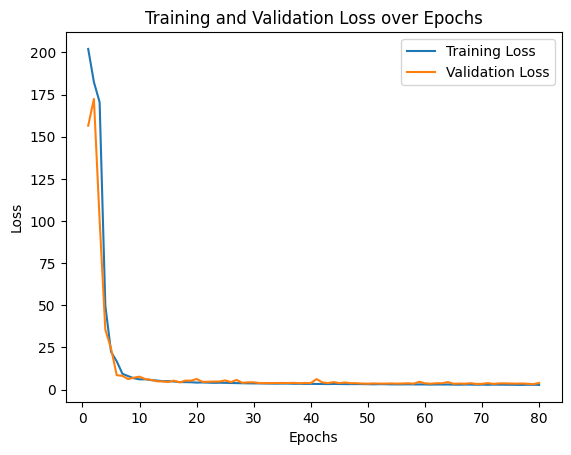

In [19]:
# Training plot
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

#### Inférence sur nos données de test

In [22]:
# Dataset for test dataloader
class moleculeTest(Dataset):
    def __init__(self, data_mol, transform=None):
        self.data_mol = data_mol
        self.transform = transform

    def __len__(self):
        return len(self.data_mol)

    def __getitem__(self, idx):
        atom = self.data_mol.iloc[idx]
        id = int(atom["id"])
        coulomb_mat = compute_coulomb_matrix(atom)
        random_coulomb = randomly_sorted_coulomb(coulomb_mat, sigma)
        x = transform_coulomb_matrix(random_coulomb, theta)
        x = torch.tensor(x, dtype=torch.float32)  
        if self.transform:
            x = self.transform(x)
        return x, id

In [23]:
# Dataloader
test = moleculeTest(data_test_mol)
testloader = DataLoader(test, batch_size=batch_size, shuffle=False)

# Load weight
model.load_state_dict(torch.load(weights_path))
model.eval()

predictions = []
with torch.no_grad():
    for _, data in enumerate(testloader):
        x = data[0].to(device)
        id = data[1].item()
        outputs = model(x)
        energy_pred = outputs.item()  
        predictions.append({
            'id': id,
            'energy': energy_pred
        })
predictions_df = pd.DataFrame(predictions)
predictions_df = predictions_df.sort_values(by='id').reset_index(drop=True)
# Save to csv
output_csv = 'predictions_coulomb.csv'
predictions_df.to_csv(output_csv, index=False)

## Méthode du scattering 3D

#### Features

In [21]:
positions = np.stack([np.stack(data_mol[col]) for col in data_mol[["x", "y", "z"]].columns]).transpose((1, 2, 0))
charges = np.stack(data_mol["atomic_numbers"])

In [22]:
mask = charges <= 2
valence_charges = charges * mask

mask = np.logical_and(charges > 2, charges <= 10)
valence_charges += (charges - 2) * mask

mask = np.logical_and(charges > 10, charges <= 18)
valence_charges += (charges - 10) * mask

overlapping_precision = 1e-1
sigma = 2.0
min_dist = np.inf
n_molecules = data.shape[0]

for i in range(n_molecules):
    n_atoms = np.sum(charges[i] != 0)
    positions_i = positions[i, :n_atoms, :]
    min_dist = min(min_dist, pdist(positions_i).min())

delta = sigma * np.sqrt(-8 * np.log(overlapping_precision))
positions = positions * delta / min_dist

M, N, O = 192, 128, 96

grid = np.mgrid[-M//2:-M//2+M, -N//2:-N//2+N, -O//2:-O//2+O]
grid = np.fft.ifftshift(grid)

#### Modèle

In [ ]:
J = 2
L = 3
integral_powers = [0.5, 1.0, 2.0, 3.0]

scattering = HarmonicScattering3D(J=J, shape=(M, N, O),
                                  L=L, sigma_0=sigma,
                                  integral_powers=integral_powers)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
scattering.to(device)
batch_size = 8
n_batches = int(np.ceil(n_molecules / batch_size))

#### Features extraction

In [ ]:
order_0, orders_1_and_2 = [], []
print('Computing solid harmonic scattering coefficients of '
      '{} molecules from the QM7 database on {}'.format(
        n_molecules,   "GPU" if use_cuda else "CPU"))
print('sigma: {}, L: {}, J: {}, integral powers: {}'.format(
        sigma, L, J, integral_powers))

this_time = None
last_time = None
for i in range(n_batches):
    this_time = time.time()
    if last_time is not None:
        dt = this_time - last_time
        print("Iteration {} ETA: [{:02}:{:02}:{:02}]".format(
                    i + 1, int(((n_batches - i - 1) * dt) // 3600),
                    int((((n_batches - i - 1) * dt) // 60) % 60),
                    int(((n_batches - i - 1) * dt) % 60)))
    else:
        print("Iteration {} ETA: {}".format(i + 1, '-'))
    last_time = this_time
    time.sleep(1)

    # Extract the current batch.
    start = i * batch_size
    end = min(start + batch_size, n_molecules)

    pos_batch = positions[start:end]
    full_batch = charges[start:end]
    val_batch = valence_charges[start:end]

    # Calculate the density map for the nuclear charges and transfer
    # to PyTorch.
    full_density_batch = generate_weighted_sum_of_gaussians(grid,
            pos_batch, full_batch, sigma)
    full_density_batch = torch.from_numpy(full_density_batch)
    full_density_batch = full_density_batch.to(device).float()

    # Compute zeroth-order, first-order, and second-order scattering
    # coefficients of the nuclear charges.
    full_order_0 = TorchBackend3D.compute_integrals(full_density_batch,
                                     integral_powers)
    full_scattering = scattering(full_density_batch)

    # Compute the map for valence charges.
    val_density_batch = generate_weighted_sum_of_gaussians(grid,
            pos_batch, val_batch, sigma)
    val_density_batch = torch.from_numpy(val_density_batch)
    val_density_batch = val_density_batch.to(device).float()

    # Compute scattering coefficients for the valence charges.
    val_order_0 = TorchBackend3D.compute_integrals(val_density_batch,
                                    integral_powers)
    val_scattering = scattering(val_density_batch)

    # Take the difference between nuclear and valence charges, then
    # compute the corresponding scattering coefficients.
    core_density_batch = full_density_batch - val_density_batch

    core_order_0 = TorchBackend3D.compute_integrals(core_density_batch,
                                     integral_powers)
    core_scattering = scattering(core_density_batch)

    # Stack the nuclear, valence, and core coefficients into arrays
    # and append them to the output.
    batch_order_0 = torch.stack(
        (full_order_0, val_order_0, core_order_0), dim=-1)
    batch_orders_1_and_2 = torch.stack(
        (full_scattering, val_scattering, core_scattering), dim=-1)

    order_0.append(batch_order_0)
    orders_1_and_2.append(batch_orders_1_and_2)

In [ ]:
order_0 = torch.cat(order_0, dim=0)
orders_1_and_2 = torch.cat(orders_1_and_2, dim=0)

order_0 = order_0.cpu().numpy()
orders_1_and_2 = orders_1_and_2.cpu().numpy()

order_0 = order_0.reshape((n_molecules, -1))
orders_1_and_2 = orders_1_and_2.reshape((n_molecules, -1))

#### Load le modèle

In [23]:
# Load train
order_0 = np.load('order0.npy')
orders_1_and_2 = np.load('order1_2.npy')
data = pd.read_pickle("dataframe.pkl")
merged = pd.merge(data, energies, how="left", on="id")

In [24]:
scattering_coef = np.concatenate([order_0, orders_1_and_2], axis=1)

In [25]:
scattering_coef.shape

(4628, 300)

In [26]:
n_folds = 13
n_molecules = 4628
P = np.random.permutation(n_molecules).reshape((n_folds, -1))
cross_val_folds = []

for i_fold in range(n_folds):
    fold = (np.concatenate(P[np.arange(n_folds) != i_fold], axis=0),
            P[i_fold])
    cross_val_folds.append(fold)

#### Entraînement

In [27]:
alphas = 10.0 ** (-np.arange(1, 10))
MAEs = []
RMSEs = []
for i, alpha in enumerate(alphas):
    scaler = preprocessing.StandardScaler()
    ridge = linear_model.Ridge(alpha=alpha)
    ridge.fit(X=scattering_coef, y=merged["energy"])
    regressor = pipeline.make_pipeline(scaler, ridge)

    target_prediction = model_selection.cross_val_predict(regressor,
            X=scattering_coef, y=merged['energy'], cv=cross_val_folds)

    MAE = np.mean(np.abs(target_prediction - merged['energy']))
    RMSE = np.sqrt(np.mean((target_prediction - merged['energy']) ** 2))

    MAEs.append(MAE)
    RMSEs.append(RMSE)
    print('Ridge regression, alpha: {}, MAE: {}, RMSE: {}'.format(
        alpha, MAE, RMSE))

/home/mickael/venv/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning:

Ill-conditioned matrix (rcond=1.68536e-08): result may not be accurate.

/home/mickael/venv/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning:

Ill-conditioned matrix (rcond=1.23446e-08): result may not be accurate.

/home/mickael/venv/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning:

Ill-conditioned matrix (rcond=2.68648e-08): result may not be accurate.

/home/mickael/venv/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning:

Ill-conditioned matrix (rcond=2.31836e-08): result may not be accurate.

/home/mickael/venv/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning:

Ill-conditioned matrix (rcond=1.72511e-08): result may not be accurate.

/home/mickael/venv/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning:

Ill-conditioned matrix (rcond=2.42193e-08

Ridge regression, alpha: 0.1, MAE: 0.11000644926854734, RMSE: 0.1539376993507647
Ridge regression, alpha: 0.01, MAE: 0.07502916241902766, RMSE: 0.11116256707458151
Ridge regression, alpha: 0.001, MAE: 0.056911668278528275, RMSE: 0.09387242399166149
Ridge regression, alpha: 0.0001, MAE: 0.04602225940672042, RMSE: 0.07758463442125321
Ridge regression, alpha: 9.999999999999999e-06, MAE: 0.04054303989647841, RMSE: 0.06515161250061409
Ridge regression, alpha: 1e-06, MAE: 0.038363892164561667, RMSE: 0.06650130532977389
Ridge regression, alpha: 1e-07, MAE: 0.036212747096907055, RMSE: 0.07155207750531122
Ridge regression, alpha: 1e-08, MAE: 0.035221693080567044, RMSE: 0.07789333353170613
Ridge regression, alpha: 1e-09, MAE: 0.034735475579717914, RMSE: 0.07574682949799282


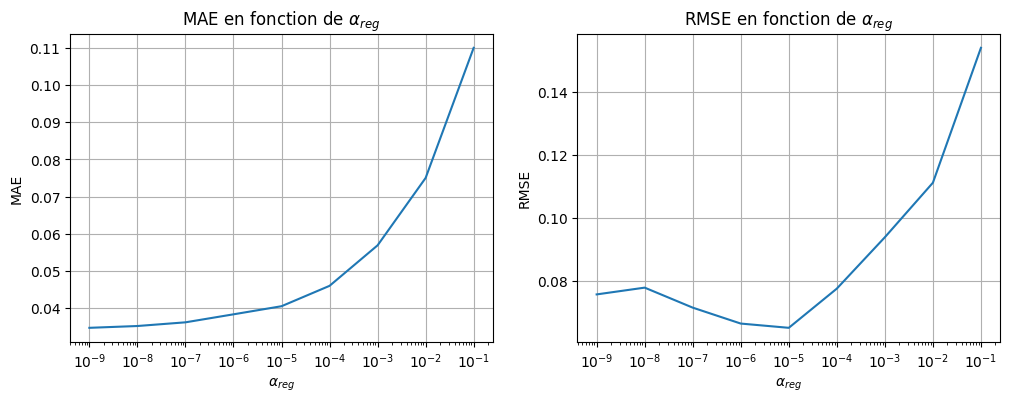

In [28]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.semilogx(alphas, MAEs)
plt.xlabel(r"$\alpha_{reg}$")
plt.ylabel("MAE")
plt.title(r"MAE en fonction de $\alpha_{reg}$")
plt.grid(True)
plt.subplot(1, 2, 2)
plt.semilogx(alphas, RMSEs)
plt.xlabel(r"$\alpha_{reg}$")
plt.ylabel("RMSE")
plt.title(r"RMSE en fonction de $\alpha_{reg}$")
plt.grid(True)
plt.show()

#### Entraînement et inférence avec ridge de paramètre $\alpha = \alpha_{best}$ déterminé avec les résultats précédent

In [29]:
# Load test
order_0 = np.load('order0_test.npy')
orders_1_and_2 = np.load('order1_2_test.npy')
scattering_coef_test = np.concatenate([order_0, orders_1_and_2], axis=1)
data_test = pd.read_pickle("dataframe_test.pkl")


In [30]:
best_alpha = 1e-9

# Train
scaler = preprocessing.StandardScaler()
ridge = linear_model.Ridge(alpha=best_alpha)
regressor = pipeline.make_pipeline(scaler, ridge)
regressor.fit(scattering_coef, merged['energy'])

# Test
test_predictions = regressor.predict(scattering_coef_test)
predictions_df = pd.DataFrame({
    'id': data_test['id'], 
    'energy': test_predictions
})
predictions_df = predictions_df.sort_values(by='id').reset_index(drop=True)
# Save csv
output_csv = 'predictions_scattering.csv'
predictions_df.to_csv(output_csv, index=False)